In [1]:
import sys
import sys
sys.path.append("../")
import src.soporte as sp
from fuzzywuzzy import fuzz
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
import folium
import geopy
from geopy.geocoders import Nominatim
from functools import partial 
import re
pd.options.display.max_columns = None

c:\Users\smico\anaconda3\envs\iron\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df = pd.read_csv('datos/volunteers_1v.csv', low_memory=False)
#Utilizamos low memory=False ya que al leerlo me daba un error porque en algunas columnas tienen diferentes tipos de datos, habrá que echarle un vistazo
df.head(5)

,Name,Course,Anglo Status,Date Modified,Age,Birth Date,Veteran,Gender,Nationality,Request Status,Date Modified.1,Arrival Medium,Arrival Company,Arrival Number,Travel_Alone
0,Andrew Thomas,Zujar TEENS - 2 weeks - June/30/2019 to July/1...,Bad feedback,26/01/2022 13:21,20.0,NaN,Yes,Male,IRELAND,Cleared,27/02/2019 14:35,NaN,NaN,NaN,No
1,Emily Harmon,Zujar TEENS - 2 weeks - June/30/2019 to July/1...,Approved,02/12/2019 10:21,21.0,NaN,Yes,Female,UNITED KINGDOM,Cleared,20/03/2019 12:47,NaN,NaN,NaN,No
2,Norma Nelson,Zujar TEENS - 2 weeks - June/30/2019 to July/1...,Approved,12/05/2021 12:02,20.0,NaN,Yes,Female,CANADA,Veteran,22/05/2019 18:18,NaN,NaN,NaN,No
3,Sandra Gonzales,Zujar TEENS - 2 weeks - July/2/2017 to July/15...,Approved,09/03/2022 12:19,21.0,NaN,Yes,Female,IRELAND,Cleared,11/05/2017 14:43,NaN,NaN,NaN,No
4,Annette Robinson,Zujar TEENS - 2 weeks - July/2/2017 to July/15...,Approved,22/06/2021 23:03,23.0,NaN,Yes,Female,USA,Cleared,24/04/2017 14:05,NaN,NaN,NaN,No


In [3]:
print(df.columns)

Index(['Name', 'Course', 'Anglo Status', 'Date Modified', 'Age', 'Birth Date',
       'Veteran', 'Gender', 'Nationality ', 'Request Status',
       'Date Modified.1', 'Arrival Medium', 'Arrival Company',
       'Arrival Number', 'Travel_Alone'],
      dtype='object')


In [4]:
# Reemplaza los espacios por subrayados en los nombres de las columnas
df.columns= df.columns.str.lstrip()
df.columns= df.columns.str.rstrip()
df.columns = df.columns.str.replace(" ", "_")
df.head(2)

,Name,Course,Anglo_Status,Date_Modified,Age,Birth_Date,Veteran,Gender,Nationality,Request_Status,Date_Modified.1,Arrival_Medium,Arrival_Company,Arrival_Number,Travel_Alone
0,Andrew Thomas,Zujar TEENS - 2 weeks - June/30/2019 to July/1...,Bad feedback,26/01/2022 13:21,20.0,NaN,Yes,Male,IRELAND,Cleared,27/02/2019 14:35,NaN,NaN,NaN,No
1,Emily Harmon,Zujar TEENS - 2 weeks - June/30/2019 to July/1...,Approved,02/12/2019 10:21,21.0,NaN,Yes,Female,UNITED KINGDOM,Cleared,20/03/2019 12:47,NaN,NaN,NaN,No


In [5]:
df.shape

(91108, 15)

In [6]:
df.isnull().sum()

Name                   0
Course                 0
Anglo_Status         744
Date_Modified        742
Age                  742
Birth_Date         90366
Veteran             4496
Gender                 0
Nationality            0
Request_Status       742
Date_Modified.1      742
Arrival_Medium     90927
Arrival_Company    90928
Arrival_Number     90995
Travel_Alone           0
dtype: int64

In [7]:
#cambiamos los nulos de Anglo_Status a TBC y Veterano a "no"
df["Anglo_Status"].fillna("TBC", inplace=True)
df['Veteran'].fillna("No",inplace=True)


In [8]:
#Queremos comprobar si todos los nulos de determinadas columnas están en las mismas filas
df_comparativa_nulos=df[['Date_Modified','Age','Request_Status','Date_Modified.1']]
#sumamos los nulos por filas, axis=1
filas_na = df_comparativa_nulos[['Date_Modified', 'Age', 'Request_Status','Date_Modified.1']].isnull().sum(axis=1)
#creamos una nueva variable que almacena las filas que cumplen con la condicion de que el numero de nulos por fila sea 4
coincide = filas_na[filas_na == 4]
print(f'Tenemos {coincide} filas que tienen 4 nulos, por lo cual es cierto que todos los nulos se situan en las mismas filas')

Tenemos 90366    4
90367    4
90368    4
90369    4
90370    4
        ..
91103    4
91104    4
91105    4
91106    4
91107    4
Length: 742, dtype: int64 filas que tienen 4 nulos, por lo cual es cierto que todos los nulos se situan en las mismas filas


In [9]:
#Calculamos el porcentaje que representan los nulos
columnas_nulos = ['Date_Modified', 'Age', 'Request_Status', 'Date_Modified.1']
for col in columnas_nulos:
    porcentaje = round((df[col].isnull().sum() / df.shape[0]) * 100, 2)
    print(f"El porcentaje de valores nulos en la columna '{col}' es: {porcentaje}%")

El porcentaje de valores nulos en la columna 'Date_Modified' es: 0.81%
El porcentaje de valores nulos en la columna 'Age' es: 0.81%
El porcentaje de valores nulos en la columna 'Request_Status' es: 0.81%
El porcentaje de valores nulos en la columna 'Date_Modified.1' es: 0.81%


In [10]:
#Necesitamos una columna extra con los años en que los voluntarios han aplicado o asistido a los campamentos. La vamos a sacar del nombre de los curso
#Extraemos los años de la fecha de programa y lso añadimos a una columna nueva
df['Year'] = df['Course'].str.extract(r'(\d{4})')
#Calculamos el porcentaje de nulos en la nueva columna
porcentaje=sp.porcentaje_nulos(df,'Year')
print(f'El porcentaje de años nulos es de {porcentaje}%')

El porcentaje de años nulos es de 3.02%


In [11]:
#Eliminamos los nulos, pero lo almacenamos en un nuevo dataframe para mantener el dataframe original
df2=df.dropna(subset='Date_Modified')
nulos=df.shape[0]-df2.shape[0]
print(f'La diferencia entre el dataframe anterior y el nuevo es de {nulos}, que es el número de nulos que teniamos en las columnas analizadas')


La diferencia entre el dataframe anterior y el nuevo es de 742, que es el número de nulos que teniamos en las columnas analizadas


In [12]:
#Creamos un nuevo dataframe con aquellos datos de llegada
df_arrivals=df[df['Arrival_Number'].isnull() == False]
df_arrivals.head(2)

,Name,Course,Anglo_Status,Date_Modified,Age,Birth_Date,Veteran,Gender,Nationality,Request_Status,Date_Modified.1,Arrival_Medium,Arrival_Company,Arrival_Number,Travel_Alone,Year
90367,David Blevins,La Alberca TEENS-VOLUNTEER 2 WEEKS from 07/02/...,TBC,NaN,NaN,17/06/2004,Yes,Male,USA,NaN,NaN,Plane,Delta Airlines,DL126,No,2021
90373,Ann Bowman,La Alberca TEENS-VOLUNTEER 2 WEEKS from 07/09/...,TBC,NaN,NaN,10/10/2006,Yes,Female,USA,NaN,NaN,Plane,American Airlines,AA94,No,2021


In [13]:
#Eliminamos las columnas que tienen mayría de nulos para que el dataframe quede más legible
df2.drop(['Course','Arrival_Medium','Arrival_Company','Arrival_Number','Birth_Date'],axis=1,inplace=True)
df2 = df2.rename(columns={'Date_Modified.1': 'Date_Modified1'})
df2.head(2)

C:\Users\smico\AppData\Local\Temp\ipykernel_20104\2959943269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(['Course','Arrival_Medium','Arrival_Company','Arrival_Number','Birth_Date'],axis=1,inplace=True)


,Name,Anglo_Status,Date_Modified,Age,Veteran,Gender,Nationality,Request_Status,Date_Modified1,Travel_Alone,Year
0,Andrew Thomas,Bad feedback,26/01/2022 13:21,20.0,Yes,Male,IRELAND,Cleared,27/02/2019 14:35,No,2019
1,Emily Harmon,Approved,02/12/2019 10:21,21.0,Yes,Female,UNITED KINGDOM,Cleared,20/03/2019 12:47,No,2019


In [14]:
df2.isnull().sum()

Name                 0
Anglo_Status         0
Date_Modified        0
Age                  0
Veteran              0
Gender               0
Nationality          0
Request_Status       0
Date_Modified1       0
Travel_Alone         0
Year              2748
dtype: int64

In [15]:
#Necesitamos una columna extra con los años en que los voluntarios han aplicado o asistido a los campamentos. La vamos a sacar del nombre de los curso
#Extraemos los años de la fecha de programa y lso añadimos a una columna nueva
#df2['Year'] = df2['Course'].str.extract(r'(\d{4})')
#Calculamos el porcentaje de nulos en la nueva columna
#porcentaje=sp.porcentaje_nulos(df2,'Year')
#print(f'El porcentaje de años nulos es de {porcentaje}%')

In [16]:
#Sustituimos los nulos por el valor siguiente
df2['Year'].fillna(method='ffill', inplace=True)
df2['Year'].isnull().sum()

0

Ya lo tenemos sin nulos, vamos a analizar la información.

In [17]:
#Valores únicos
df2.apply(pd.Series.nunique)

Name              12612
Anglo_Status         17
Date_Modified     24768
Age                  86
Veteran               2
Gender                2
Nationality         188
Request_Status       18
Date_Modified1    41700
Travel_Alone          1
Year                 16
dtype: int64

In [18]:
df2.to_csv("datos/aplicaciones.csv",index=False, header=True)

In [19]:
import warnings
warnings.filterwarnings("ignore")
#La primera vez que hemos corrido el código nos ha dado un error así que usamos la libreria Warnings
#Eliminamos los duplicados de la columna 'Name'
df_unicos = df2.drop_duplicates(subset='Name', inplace=False)
df_unicos.head(2)


,Name,Anglo_Status,Date_Modified,Age,Veteran,Gender,Nationality,Request_Status,Date_Modified1,Travel_Alone,Year
0,Andrew Thomas,Bad feedback,26/01/2022 13:21,20.0,Yes,Male,IRELAND,Cleared,27/02/2019 14:35,No,2019
1,Emily Harmon,Approved,02/12/2019 10:21,21.0,Yes,Female,UNITED KINGDOM,Cleared,20/03/2019 12:47,No,2019


In [20]:
df_unicos.drop(['Anglo_Status','Date_Modified','Request_Status','Date_Modified.1'],axis=1,inplace=True)
df_unicos.head(2)

KeyError: "['Date_Modified.1'] not found in axis"

In [ ]:
df_unicos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12612 entries, 0 to 90293
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          12612 non-null  object 
 1   Age           12612 non-null  float64
 2   Veteran       12612 non-null  object 
 3   Gender        12612 non-null  object 
 4   Nationality   12612 non-null  object 
 5   Travel_Alone  12612 non-null  object 
 6   Year          12612 non-null  object 
dtypes: float64(1), object(6)
memory usage: 788.2+ KB


In [ ]:
df_unicos['Age'].astype(int)


0        20
1        21
2        20
3        21
4        23
         ..
89311    63
89558    72
89679    59
90187    59
90293    73
Name: Age, Length: 12612, dtype: int32

In [ ]:
df_unicos.to_csv("datos/voluntarios_unicos.csv",index=False, header=True)

In [ ]:
df_unicos.isnull().sum()

Name            0
Age             0
Veteran         0
Gender          0
Nationality     0
Travel_Alone    0
Year            0
dtype: int64

In [ ]:
#Hipotesis1: el mayor grupo de voluntarios pertenece al grupo de 41-60, tanto en aplicaciones como en voluntarios reales
#Vamos a crear dos dataframes, uno que solo contenga los veteranos y otro con todos pero solo las columnas necesarias, en los casos necesitamos que sean mayores de 18
#Seleccionamos aquellos que son mayores de 18
df_edad_reales = df_unicos[df_unicos['Age'] >= 18]
print(df_edad_reales['Age'].sort_values())
df_edad_totales=df2[df2['Age']>=18]
df_edad_totales.drop(['Anglo_Status','Date_Modified','Request_Status','Date_Modified.1'],axis=1,inplace=True)
print(df_edad_totales['Age'].sort_values())


2936     18.0
4233     18.0
4302     18.0
4342     18.0
3311     18.0
         ... 
1506     94.0
1459     94.0
67095    94.0
23473    94.0
1715     98.0
Name: Age, Length: 12588, dtype: float64
21223    18.0
108      18.0
4270     18.0
4272     18.0
53490    18.0
         ... 
87336    95.0
1752     98.0
1715     98.0
52801    99.0
52133    99.0
Name: Age, Length: 90307, dtype: float64


In [ ]:
#Creamos grupos de edad y los asignamos 
bins_age = [17, 25, 40, 60, 75, df['Age'].max()]
labels_age = ['18-25', '26-40', '41-60', '61-75', '76+']
df_edad_reales['Age_Group'] = pd.cut(df_edad_reales['Age'], bins=bins_age, labels=labels_age)
df_edad_totales['Age_Group'] = pd.cut(df_edad_totales['Age'], bins=bins_age, labels=labels_age)


In [ ]:
#Vamos a ver si se ha generado algun nulo en alguno de los campos
print(df_edad_reales.isna().sum())
print(df_edad_totales.isna().sum())


Name            0
Age             0
Veteran         0
Gender          0
Nationality     0
Travel_Alone    0
Year            0
Age_Group       0
dtype: int64
Name            0
Age             0
Veteran         0
Gender          0
Nationality     0
Travel_Alone    0
Year            0
Age_Group       0
dtype: int64


In [ ]:
mediana_age_reales=df_edad_reales['Age'].median()
mediana_age_totales=df_edad_totales['Age'].median()

In [ ]:
#La primera comprobacion será entre los grupos de edades por aplicaciones y reales. >Les separamos en dos dtaframes que usaremos para las gráficas
age_groups_real = df_edad_reales.groupby(['Age_Group']).size().reset_index(name='Total')
age_groups_total= df_edad_totales.groupby(['Age_Group']).size().reset_index(name='Total')


In [ ]:
#Llamamos a la función porcentaje que está guardada en soporte.py
age_groups_real['Porcentaje']=sp.porcentaje(age_groups_real,'Total')
age_groups_total['Porcentaje']=sp.porcentaje(age_groups_total,'Total')
print(age_groups_real)
print(age_groups_total)

  Age_Group  Total  Porcentaje
0     18-25   1799       14.29
1     26-40   5495       43.65
2     41-60   2382       18.92
3     61-75   2391       18.99
4       76+    521        4.14
  Age_Group  Total  Porcentaje
0     18-25  10010       11.08
1     26-40  34833       38.57
2     41-60  17688       19.59
3     61-75  21231       23.51
4       76+   6545        7.25


'for i, bar in enumerate(ax.patches):\n   ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height()  +1.5,\n        f"{gender_groups[\'Porcentaje\'][i]}",\n        horizontalalignment= \'center\', verticalalignment=\'bottom\',\n        fontsize=15, rotation=0, color=\'black\')'

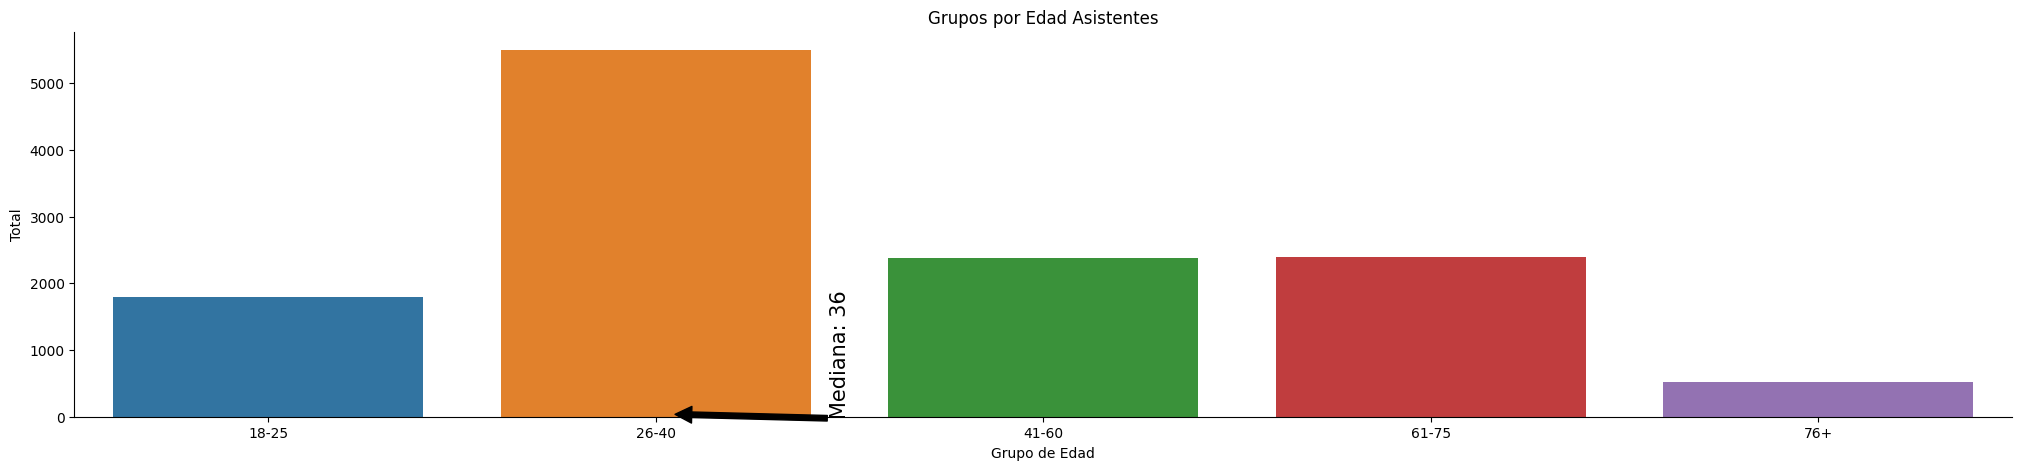

In [ ]:
sp.graf_barras(mediana_age_reales,'Age_Group', 'Total', age_groups_real,'Grupo de Edad', 'Total','Grupos por Edad Asistentes')

"""for i, bar in enumerate(ax.patches):
   ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height()  +1.5,
        f"{gender_groups['Porcentaje'][i]}",
        horizontalalignment= 'center', verticalalignment='bottom',
        fontsize=15, rotation=0, color='black')"""

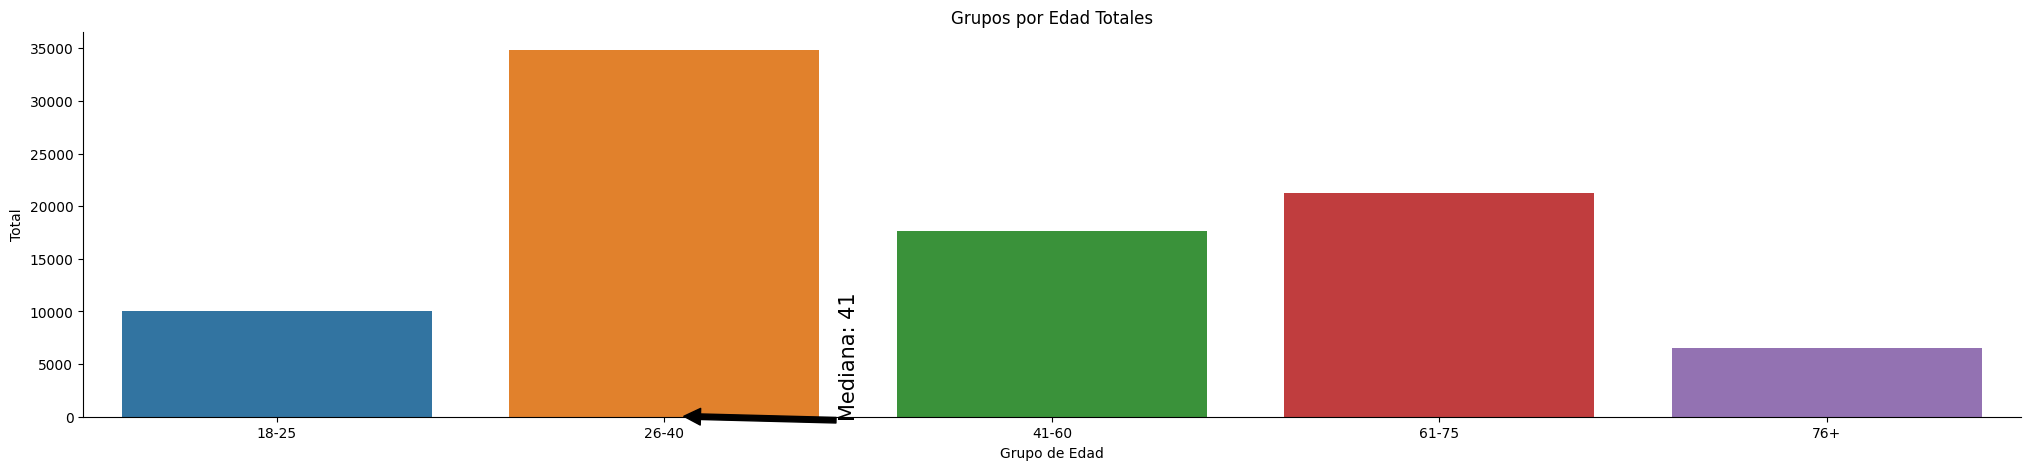

In [ ]:
sp.graf_barras(mediana_age_totales,'Age_Group', 'Total', age_groups_total,'Grupo de Edad', 'Total','Grupos por Edad Totales')

In [ ]:

timeline_age_real=df_edad_reales.groupby(['Year', 'Age_Group']).sum()
timeline_age_real=timeline_age_real.reset_index()
timeline_age_real.columns=['Year','Age_Group','Total']
timeline_age_totales=df_edad_totales.groupby(['Year', 'Age_Group']).sum()
timeline_age_totales=timeline_age_totales.reset_index()
timeline_age_totales.columns=['Year','Age_Group','Total']
print(timeline_age_real)
print(timeline_age_totales)



    Year Age_Group   Total
0   2004     18-25   215.0
1   2004     26-40    69.0
2   2004     41-60   171.0
3   2004     61-75   696.0
4   2004       76+   318.0
..   ...       ...     ...
70  2023     18-25   127.0
71  2023     26-40    61.0
72  2023     41-60  1034.0
73  2023     61-75  2272.0
74  2023       76+   474.0

[75 rows x 3 columns]
    Year Age_Group    Total
0   2004     18-25   2134.0
1   2004     26-40   2430.0
2   2004     41-60   7339.0
3   2004     61-75  18157.0
4   2004       76+   9236.0
..   ...       ...      ...
75  2023     18-25    669.0
76  2023     26-40   2339.0
77  2023     41-60   6793.0
78  2023     61-75  21184.0
79  2023       76+   2741.0

[80 rows x 3 columns]


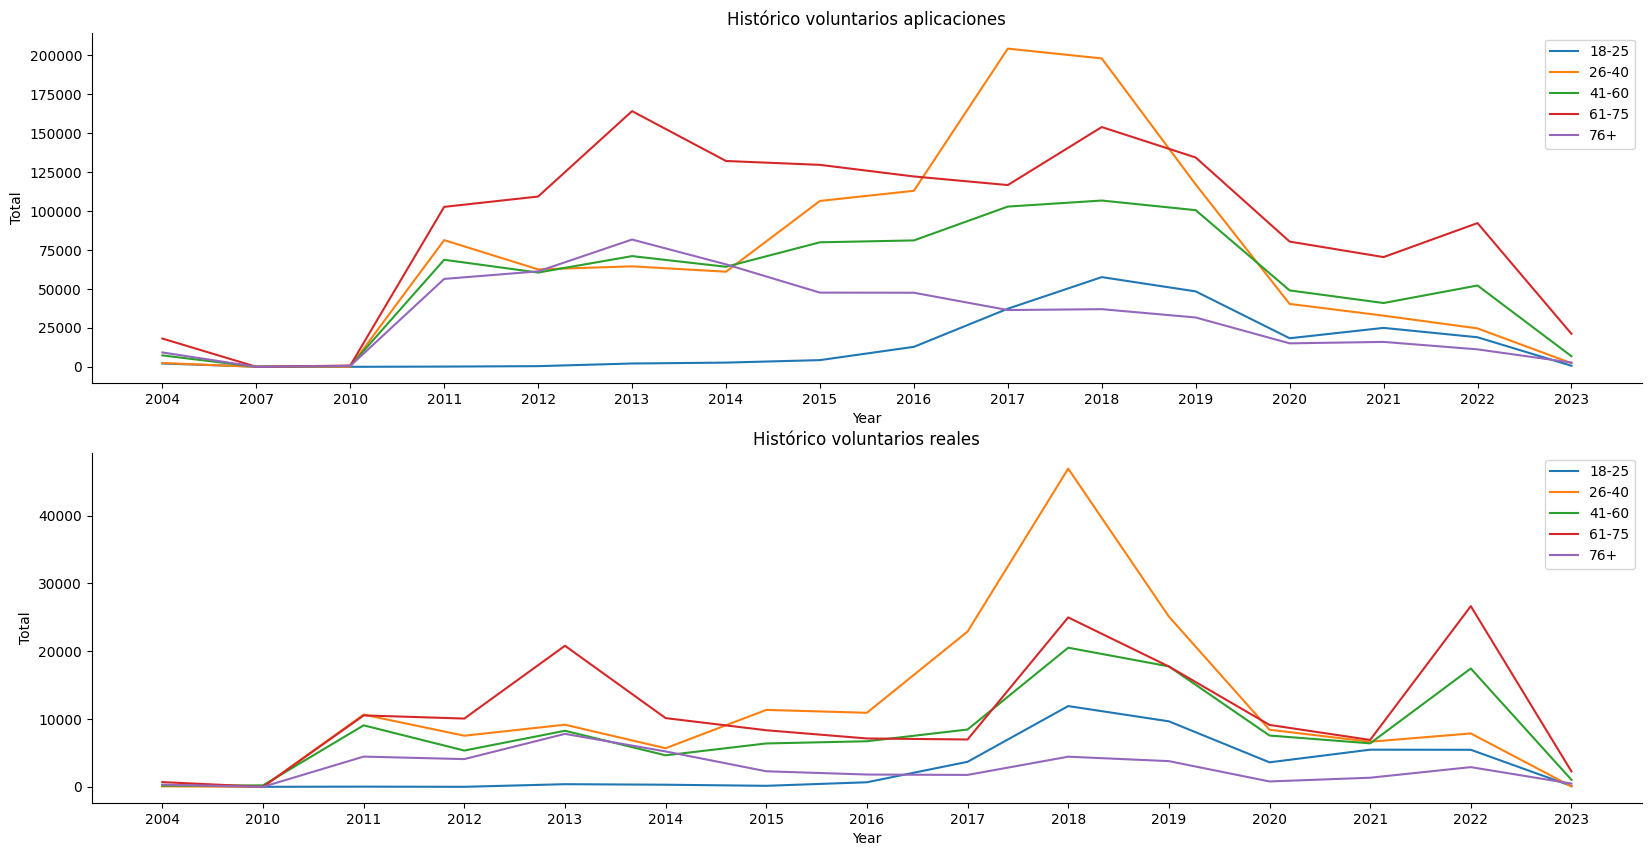

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
plt.subplot(2, 1, 1)
for group in timeline_age_totales['Age_Group'].unique():
    subset = timeline_age_totales[timeline_age_totales['Age_Group'] == group]
    plt.plot(subset['Year'], subset['Total'], label=group)
plt.xlabel('Year')
plt.ylabel('Total')
plt.legend()
plt.title('Histórico voluntarios aplicaciones')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.axvline(x=2020, color='red', linestyle='dashed')



# Crear el segundo gráfico
plt.subplot(2, 1, 2)
for group in timeline_age_real['Age_Group'].unique():
    subset = timeline_age_real[timeline_age_real['Age_Group'] == group]
    plt.plot(subset['Year'], subset['Total'], label=group)
plt.xlabel('Year')
plt.ylabel('Total')
plt.legend()
plt.title('Histórico voluntarios reales')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)



# Mostrar los gráficos
plt.show()





In [ ]:
df_pais_asistente = pd.DataFrame(df_unicos.groupby(['Nationality'])
                      ["Year"].count()).reset_index()

df_pais_asistente.rename({'Year': 'Total'}, axis=1, inplace=True)

df_pais_asistente['Porcentaje']=sp.porcentaje(df_pais_asistente,'Total')


df_pais_asistente['Nationality_groups']=np.where(df_pais_asistente['Porcentaje']<2,'OTHERS',df_pais_asistente['Nationality'])
print(df_pais_asistente)

df_pais_asistente_grupo = pd.DataFrame(df_pais_asistente.groupby(['Nationality_groups'])
                      ['Porcentaje','Total'].sum()).reset_index()

df_pais_asistente_grupo=df_pais_asistente_grupo.sort_values(by='Porcentaje',ascending=False)
df_pais_asistente_grupo

        Nationality  Total  Porcentaje Nationality_groups
0         ABU DHABI      1        0.01             OTHERS
1       AFGHANISTAN      3        0.02             OTHERS
2           ALBANIA     17        0.13             OTHERS
3           ALGERIA    130        1.03             OTHERS
4    AMERICAN SAMOA     14        0.11             OTHERS
..              ...    ...         ...                ...
155         VIETNAM      8        0.06             OTHERS
156     WEST INDIES      3        0.02             OTHERS
157           YEMEN     10        0.08             OTHERS
158          ZAMBIA     16        0.13             OTHERS
159        ZIMBABWE     24        0.19             OTHERS

[160 rows x 4 columns]


,Nationality_groups,Porcentaje,Total
8,USA,43.09,5435
6,OTHERS,18.48,2319
7,UNITED KINGDOM,13.41,1691
1,CANADA,8.27,1043
2,INDIA,6.71,846
0,AUSTRALIA,2.93,369
3,IRELAND,2.66,336
5,NIGERIA,2.45,309
4,MOROCCO,2.09,264


In [ ]:
df_pais_totales = pd.DataFrame(df2.groupby(['Nationality'])
                      ["Year"].count()).reset_index()

df_pais_totales.rename({'Year': 'Total'}, axis=1, inplace=True)

df_pais_totales['Porcentaje']=sp.porcentaje(df_pais_totales,'Total')


df_pais_totales['Nationality_groups']=np.where(df_pais_totales['Porcentaje']<2,'OTHERS',df_pais_totales['Nationality'])
print(df_pais_totales)

df_pais_totales_grupo = pd.DataFrame(df_pais_totales.groupby(['Nationality_groups'])
                      ['Porcentaje','Total'].sum()).reset_index()

df_pais_totales_grupo=df_pais_totales_grupo.sort_values(by='Porcentaje',ascending=False)
df_pais_totales_grupo

        Nationality  Total  Porcentaje Nationality_groups
0         ABU DHABI      6        0.01             OTHERS
1       AFGHANISTAN     27        0.03             OTHERS
2           ALBANIA     76        0.08             OTHERS
3           ALGERIA    725        0.80             OTHERS
4    AMERICAN SAMOA     95        0.11             OTHERS
..              ...    ...         ...                ...
183         VIETNAM     48        0.05             OTHERS
184     WEST INDIES     12        0.01             OTHERS
185           YEMEN     42        0.05             OTHERS
186          ZAMBIA     67        0.07             OTHERS
187        ZIMBABWE    129        0.14             OTHERS

[188 rows x 4 columns]


,Nationality_groups,Porcentaje,Total
6,USA,44.65,40348
4,OTHERS,17.86,16164
5,UNITED KINGDOM,16.65,15042
1,CANADA,9.21,8323
2,INDIA,5.40,4881
3,IRELAND,3.20,2896
0,AUSTRALIA,3.00,2712


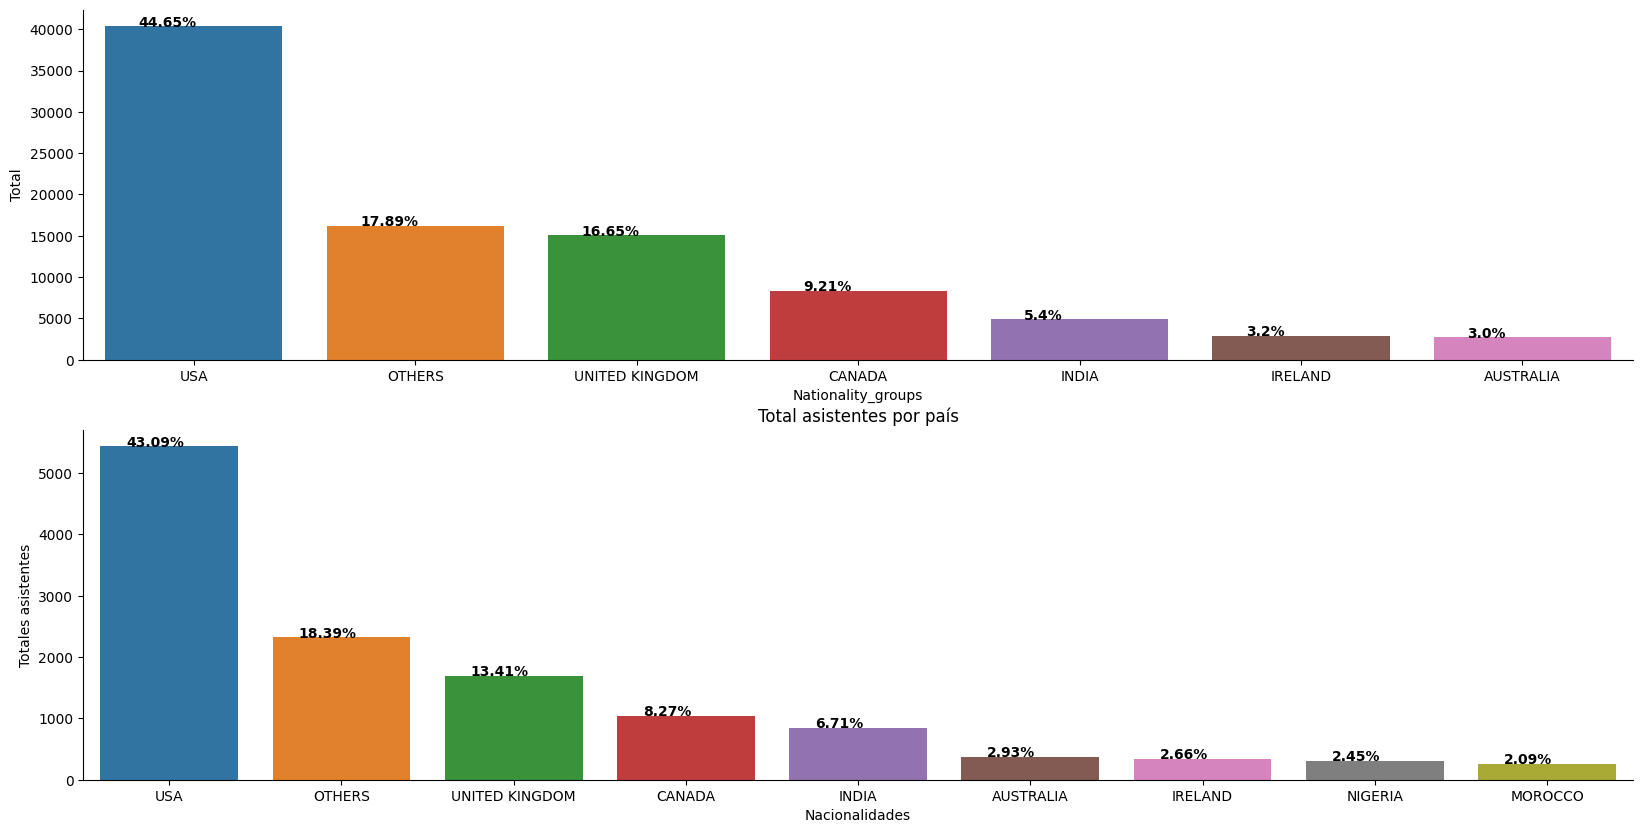

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

ax = sns.barplot(x='Nationality_groups', y='Total', data=df_pais_totales_grupo, ax=axs[0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Nacionalidades')
plt.ylabel('Totales aplicaciones')
plt.title('Total aplicaciones por país')
for i, v in enumerate(df_pais_totales_grupo['Total']):
    ax.text(i-.25, v+0.25, str(round(v/df_pais_totales_grupo['Total'].sum()*100, 2)) + '%', color='black', fontweight='bold')

ax = sns.barplot(x='Nationality_groups', y='Total', data=df_pais_asistente_grupo, ax=axs[1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Nacionalidades')
plt.ylabel('Totales asistentes')
plt.title('Total asistentes por país')

for i, v in enumerate(df_pais_asistente_grupo['Total']):
    ax.text(i-.25, v+0.25, str(round(v/df_pais_asistente_grupo['Total'].sum()*100, 2)) + '%', color='black', fontweight='bold')



In [ ]:
df_nacionalidad_otros=df_pais_asistente[df_pais_asistente['Nationality_groups']=='OTHERS']
df_nacionalidad_otros.sort_values(by='Porcentaje',ascending=False)
df_nacionalidad_otros['Nationality']=df_nacionalidad_otros['Nationality'].str.title()

In [ ]:
df_paises = pd.read_csv('datos/paises.csv')
df_paises= df_paises.drop(['M49_Code', 'Region1', 'Region2'], axis=1)
df_paises

,Country,ISO_Code,Continent
0,Afghanistan,AFG,Asia
1,Åland Islands,ALA,Europe
2,Albania,ALB,Europe
3,Algeria,DZA,Africa
4,American Samoa,ASM,Oceania
...,...,...,...
244,Wallis and Futuna Islands,WLF,Oceania
245,Western Sahara,ESH,Africa
246,Yemen,YEM,Asia
247,Zambia,ZMB,Africa


In [ ]:
df_paises.isnull().sum()

Country      0
ISO_Code     0
Continent    0
dtype: int64

In [ ]:
continentes = pd.merge(df_nacionalidad_otros, df_paises, left_on='Nationality', right_on='Country', how='inner')
continentes=continentes.drop(['Nationality_groups','Country'],axis=1)
continentes.sort_values(by='Porcentaje',ascending=False,inplace=True)
continentes

,Nationality,Total,Porcentaje,ISO_Code,Continent
101,South Africa,163,1.29,ZAF,Africa
45,Ghana,145,1.15,GHA,Africa
89,Philippines,139,1.10,PHL,Asia
2,Algeria,130,1.03,DZA,Africa
85,Pakistan,124,0.98,PAK,Asia
...,...,...,...,...,...
73,Maldives,1,0.01,MDV,Asia
115,Vanuatu,1,0.01,VUT,Oceania
5,Antarctica,1,0.01,ATA,Antarctica
4,Angola,1,0.01,AGO,Africa


In [ ]:
continentes.isnull().sum()

Nationality    0
Total          0
Porcentaje     0
ISO_Code       0
Continent      0
dtype: int64

In [ ]:
continente_group=continentes.groupby('Continent')['Total'].sum().reset_index()
continente_group['Porcentaje']=sp.porcentaje(continente_group,'Total')
continente_group=continente_group.sort_values(by='Porcentaje',ascending=False)
continente_group

,Continent,Total,Porcentaje
0,Africa,880,41.37
2,Asia,593,27.88
3,Europe,319,15.00
4,North America,163,7.66
5,Oceania,121,5.69
6,South America,50,2.35
1,Antarctica,1,0.05


In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")
geocode = partial(geolocator.geocode, language="en")


In [ ]:
locator = Nominatim(user_agent="pepe")
geocode = partial(geolocator.geocode, language="en")

continentes['capital_coordinates'] = continentes['Nationality'].apply(lambda x: geolocator.geocode(x+', capital', timeout=10).point if geolocator.geocode(x+', capital', timeout=10) else None)

In [ ]:
continentes = continentes.dropna(subset=['capital_coordinates']).reset_index(drop=True)
continentes['capital_coordinates'].isnull().sum()

0

In [ ]:
continentes.to_csv("datos/continentes.csv",index=False, header=True)

In [ ]:

map = folium.Map()

def convert_coordinates(point):
    if point is None:
        return None
    return [point.latitude, point.longitude]

# Apply the function to the capital_coordinates column
continentes["capital_coordinates"] = continentes["capital_coordinates"].apply(convert_coordinates)

# Iterate over the dataframe and add marker
for index, row in continentes.iterrows():
    if any(pd.isna(x) for x in row['capital_coordinates']):
        continue
    marker = folium.Marker(location=row['capital_coordinates'], 
                           popup=f"Country: {row['Nationality']} <br> Percentage: {row['Porcentaje']}")
    marker.add_to(map)
map


In [ ]:
veteran_counts = df2.groupby(['Name','Age']).count()
veteran_counts=veteran_counts.reset_index()
veteran_counts=veteran_counts[['Name','Age', 'Year']]
veteran_counts.rename({'Year': 'Total'}, axis=1, inplace=True)
veteran_counts.sort_values(by= 'Total', ascending=False, inplace=True)
veteran_counts.head(2)


,Name,Age,Total
8617,Dr. Mark Carter,76.0,152
29092,Tracy Butler,44.0,91


In [ ]:
bins_total = [0, 1, 2, 3, 6, 10, veteran_counts['Total'].max()]
labels_total = ['1', '2' ,'3','4-6','7-10', '+10']
veteran_counts['Veterans_Group'] = pd.cut(veteran_counts['Total'], bins=bins_total, labels=labels_total)

veteran_counts['Age_Group'] = pd.cut(veteran_counts['Age'], bins=bins_age, labels=labels_age)

veteran_counts.head(2)

,Name,Age,Total,Veterans_Group,Age_Group
8617,Dr. Mark Carter,76.0,152,+10,76+
29092,Tracy Butler,44.0,91,+10,41-60


In [ ]:
veteran_group_by_age= veteran_counts.groupby(['Veterans_Group','Age_Group']).count().reset_index()
veteran_group_by_age['Porcentaje']= sp.porcentaje(veteran_group_by_age,'Total')
veteran_group_by_age=veteran_group_by_age[['Veterans_Group','Age_Group','Porcentaje']]
#veteran_group.sort_values(by='Porcentaje', ascending=False, inplace=True)"""
veteran_group_by_age.head(2)

,Veterans_Group,Age_Group,Porcentaje
0,1,18-25,0.72
1,1,26-40,3.02


Text(0.5, 1.0, 'Veteranos / Grupos de edad')

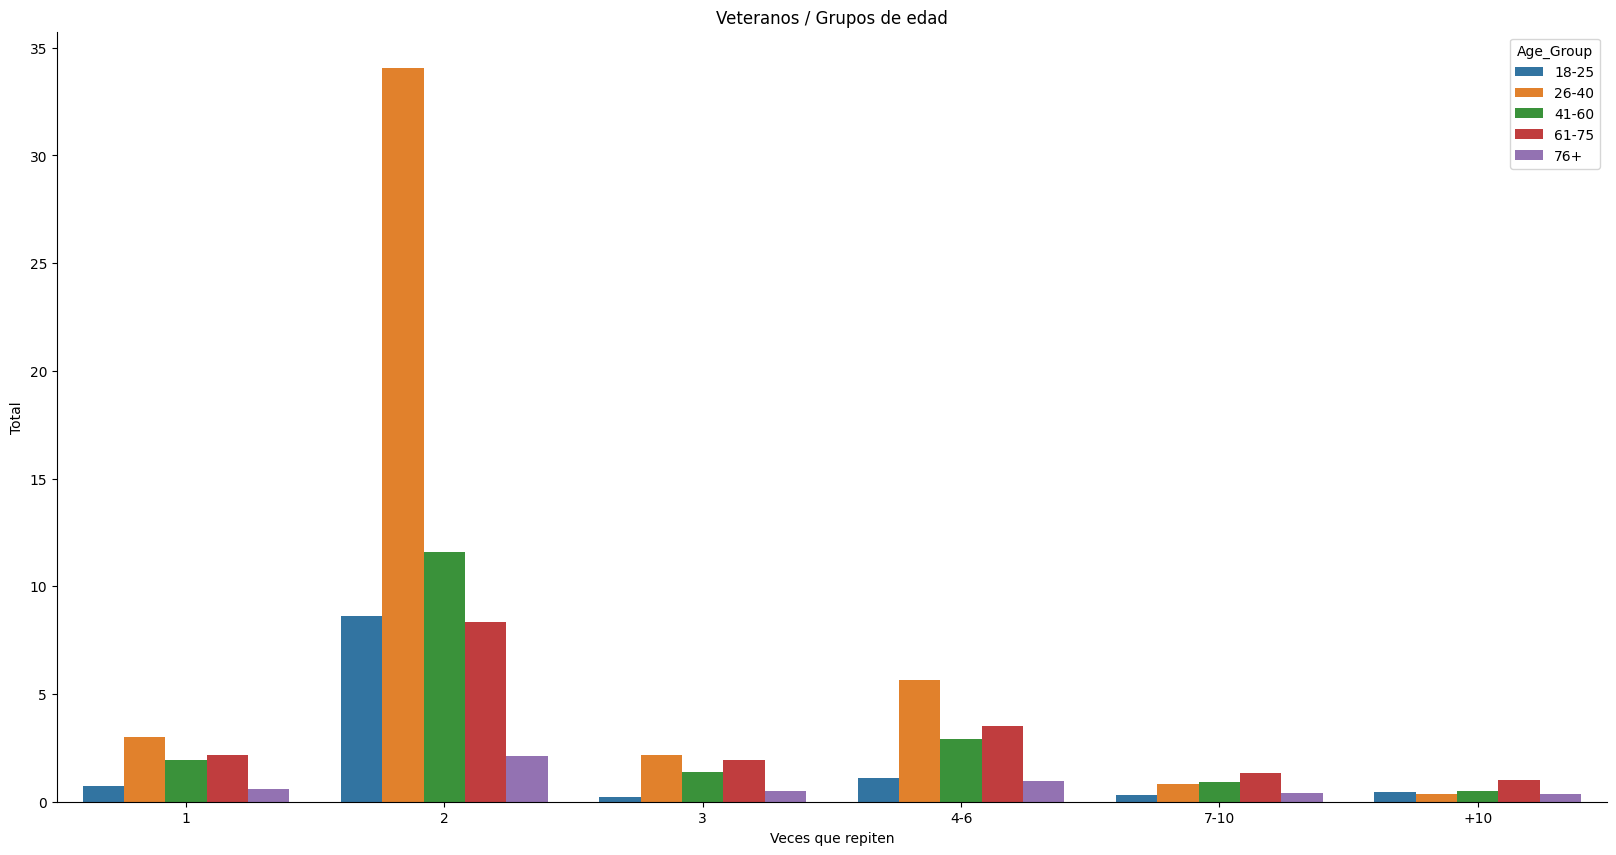

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(x='Veterans_Group', y='Porcentaje', hue='Age_Group', data=veteran_group_by_age)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Añadir etiquetas y título al gráfico
plt.xlabel('Veces que repiten')
plt.ylabel('Total')
plt.title('Veteranos / Grupos de edad')

In [ ]:

# Crear una expresión regular para buscar "TEENS" o "TEEN"
pattern = re.compile("TEENS|TEEN", re.IGNORECASE)

# Seleccionar las filas donde la columna "Course" contiene el patrón
cursos = df_arrivals[df_arrivals['Course'].str.contains(pattern)]
cursos=cursos['Course'].unique()

In [ ]:
cursos

array(['La Alberca TEENS-VOLUNTEER 2 WEEKS from 07/02/2021 to 07/16/2021',
       'La Alberca TEENS-VOLUNTEER 2 WEEKS from 07/09/2021 to 07/23/2021',
       'Valverde TEENS-VOLUNTEER 1 WEEK from 07/09/2021 to 07/16/2021',
       'La Alberca TEENS-VOLUNTEER 1 WEEK from 07/02/2021 to 07/09/2021',
       'La Alberca TEENS-VOLUNTEER 1 WEEK from 07/16/2021 to 07/23/2021',
       'La Alberca TEENS-VOLUNTEER 1 WEEK from 07/09/2021 to 07/16/2021'],
      dtype=object)

In [ ]:
cursos = pd.Series(cursos).reset_index(drop=True)
cursos=sp.dividir_serie(cursos)
cursos

,Destino,Tipo,Duración,Comienzo,Final,Nombre_completo
0,La Alberca,TEENS,2 WEEKS,07/02/2021,07/16/2021,La Alberca TEENS-VOLUNTEER 2 WEEKS from 07/02/...
1,La Alberca,TEENS,2 WEEKS,07/09/2021,07/23/2021,La Alberca TEENS-VOLUNTEER 2 WEEKS from 07/09/...
2,Valverde,TEENS,1 WEEK,07/09/2021,07/16/2021,Valverde TEENS-VOLUNTEER 1 WEEK from 07/09/202...
3,La Alberca,TEENS,1 WEEK,07/02/2021,07/09/2021,La Alberca TEENS-VOLUNTEER 1 WEEK from 07/02/2...
4,La Alberca,TEENS,1 WEEK,07/16/2021,07/23/2021,La Alberca TEENS-VOLUNTEER 1 WEEK from 07/16/2...
5,La Alberca,TEENS,1 WEEK,07/09/2021,07/16/2021,La Alberca TEENS-VOLUNTEER 1 WEEK from 07/09/2...


In [ ]:
cursos.to_csv("datos/cursos_teens.csv",index=False, header=True)

In [ ]:
df_arrivals=df_arrivals[['Course', 'Birth_Date', 'Gender','Nationality','Arrival_Medium','Arrival_Company','Arrival_Number','Name']]
df_arrivals

,Course,Birth_Date,Gender,Nationality,Arrival_Medium,Arrival_Company,Arrival_Number,Name
90367,La Alberca TEENS-VOLUNTEER 2 WEEKS from 07/02/...,17/06/2004,Male,USA,Plane,Delta Airlines,DL126,David Blevins
90373,La Alberca TEENS-VOLUNTEER 2 WEEKS from 07/09/...,10/10/2006,Female,USA,Plane,American Airlines,AA94,Ann Bowman
90384,La Alberca TEENS-VOLUNTEER 2 WEEKS from 07/09/...,05/11/2004,Male,UNITED KINGDOM,Train,Metro de Madrid,Line 8,John Turner
90386,Valverde TEENS-VOLUNTEER 1 WEEK from 07/09/202...,24/10/2004,Female,UNITED KINGDOM,Plane,Iberia,IB3633,Kara Daniels
90398,La Alberca TEENS-VOLUNTEER 1 WEEK from 07/02/2...,23/12/2005,Female,UNITED KINGDOM,Plane,Iberia,IB3633,Hailey Alvarez
...,...,...,...,...,...,...,...,...
91084,La Alberca TEENS-VOLUNTEER 1 WEEK from 07/02/2...,30/09/2003,Male,IRELAND,Plane,Ryanair,FR7156,Joshua Barnes
91086,La Alberca TEENS-VOLUNTEER 2 WEEKS from 07/02/...,30/09/2003,Male,IRELAND,Plane,Ryanair,FR7156,Joshua Barnes
91092,La Alberca TEENS-VOLUNTEER 1 WEEK from 07/16/2...,16/08/2004,Female,USA,Car,Milena?s Parents,Milena Car,Melissa Saunders
91097,La Alberca TEENS-VOLUNTEER 2 WEEKS from 07/09/...,13/01/2008,Male,SPAIN,Train,Renfe,AVLO 06304,Terry Davis


In [ ]:
df_arrivals.to_csv("datos/arrivals.csv",index=False, header=True)